In [1]:
%matplotlib inline
from pylab import *;
import seaborn;

/home/kostis/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# An implementation of vortical MCMC

The following is an implementation of vortical MCMC. See [1] for details. 

In [2]:
# proposal matrix
Q = array([[0,2/3.0,1/3.0],
           [1/3.0,0,2/3.0],
           [2/3.0,1/3.0,0]]);

# invariant distribution of Q
q = array([1/3.0,1/3.0,1/3.0]);

# vorticity matrix corresponding to Q and q
G = zeros([3,3]);

for i in range(3):
    for j in range(3):
        G[i,j] = q[i]*Q[i,j]-q[j]*Q[j,i]
        
# This encapsulates how much Q is non-reversible. If Q was reversible with respect to q, then G=0
print G

[[ 0.          0.11111111 -0.11111111]
 [-0.11111111  0.          0.11111111]
 [ 0.11111111 -0.11111111  0.        ]]


In [3]:
# Implementation of the vortical MCMC follows.

def vortMCMC(Q,q,p,x0=1,a=0.1,N=100):
    '''
        Markov Chain Monte Carlo with vortices. 
        
        The following code uses the proposal transition 
        matrix Q to construct a non-reversible Markov chain
        X_n with invariant distribution p. To do this, a modification 
        of the classical acceptance probability is 
        proposed in [1]. This modification adds an extra part called the
        vorticity matrix G. In this version of the code, 
        the vorticity matrix used is, 
    
            G(x,y) = q(x,y)Q(x,y)-q(y,x)Q(y,x)
            Ga(x,y) = a*G(x,y)
        
        Input:
             Q : (nxn matrix) : A transition probability matrix. Used to make proposals.
             q : (nx1 vector) : Stationary distribution corresponding to Q. 
             p : (nx1 vector) : Target distribution to sample from (unnormalized).
             x0: (1x1 integer): Initial point to start from (optional).
             a : (1x1 float)  : Parameter controling the vorticity matrix (optional). 
             N : (1x1 integer): Number of samples to create (optional).
                     
        Output:
            Xn : N samples from the invariant distribution. 
        
        Warning : 
            Plots need to be made to make sure that X_n has equilibrated to p! Then, an appropriate
            number of samples can be thrown away.
    
    '''
    M = size(Q,1); # Dimension of Q. Here Q is assumed to be a square matrix.
    
    # Construction of vorticity matrix associated with Q and q.
    G = zeros([M,M]);
    for i in range(M):
        for j in range(M):
            G[i,j] = a*(q[i]*Q[i,j]-q[j]*Q[j,i]) # Matrix elements are scaled by a. 
    
    
    x = zeros(N); # Array to store samples
    x[0] = x0;
    
    for i in range(N-1):
        # Generate proposal according to Q
        probs = cumsum(Q[x[i],:]); # Probabilities for this step.
        u = rand();
        for j in range(M):
            if(u<probs[j]):
                prop = j; 
                break;
                    
        # Calculate acceptance ratio  
        acc_ratio = (G[x[i],prop]+p[prop]*Q[prop,x[i]])/(p[x[i]]*Q[x[i],prop]);
        
        # Acceptance probability
        acc_prob  = min(1,acc_ratio);
        
        u = rand();
        
        if(u<acc_prob):# Accept sample.
            x[i+1] = prop;
        else: # Reject sample.
            x[i+1] = x[i];
        
            
    return x;
            
        
    


In [4]:
def asympVar(X,a,b):
    '''
        Estimating asymptotic variance with the method of batched means. 
        Input : 
            X : A Markov chain with b*a elements. 
            a : Number of batches to be used. 
            b : Number of elements in batches.
            
        Output:
            asv: Estimate of asymptotic variance
    '''

    Y = X.reshape(a,b); # Reshape into a * b matrix
    Y = mean(Y,axis=1); # Mean across batches
    Ym= mean(Y); 
    
    asv = 0.0;
    for i in xrange(a):
        asv = asv + (Y[i]-Ym)**2.0;
        
    asv = asv*b/(a-1.0);
    
    return asv;
    
    
    

In [7]:
# proposal matrix
Q = array([[1/2.0,1/2.0],[1/2.0,1/2.0]]);

# invariant distribution of Q
q = array([1/2.0,1/2.0]);

# Target invariant distribution
p = array([1/3.0,2/3.0]);


print p
atop = min(p/q);

print atop

M  = 100;
am = linspace(0.01,atop,M)

ans = zeros(M);

na = 30;
nb = 1000;

Num = na*nb;

for i in xrange(M):
    x = vortMCMC(Q,q,p,x0=0,a=am[i],N=Num)
    ans[i] = asympVar(x,na,nb) 
    
print 'Frequencies below should be close to the probabilities p above.'
print 'Frequency of 0 as a state : ', mean(x==0)
print 'Frequency of 1 as a state : ', mean(x==1)



[ 0.33333333  0.66666667]
0.666666666667


/home/kostis/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:45: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/kostis/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:53: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Frequencies below should be close to the probabilities p above.
Frequency of 0 as a state :  0.331733333333
Frequency of 1 as a state :  0.668266666667


Minimum asymptotic variance : 0.130998850575


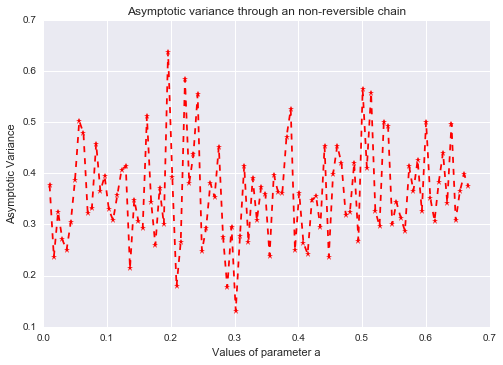

In [8]:
plot(am,ans,'r*--')
xlabel('Values of parameter a')
ylabel('Asymptotic Variance')
title('Asymptotic variance through an non-reversible chain')

print 'Minimum asymptotic variance :', min(ans)

### References

1. Non-reversible Metropolis-Hastings, Joris Bierkens, 2014